In [1]:
from ay_torch import *

In [2]:
FUNC1_KIND=3
def Func1(x):
  #NOTE: Switch the function to be learned.
  global FUNC1_KIND
  if FUNC1_KIND==0:  return x
  if FUNC1_KIND==1:  return 0.5*x**2
  if FUNC1_KIND==2:  return 0.1*x**3
  if FUNC1_KIND==3:  return 0.1*x**3-1.0*x

FUNC2_KIND=3
def Func2(x):
  #NOTE: Switch the function to be learned.
  global FUNC2_KIND
  if FUNC2_KIND==0:  return x
  if FUNC2_KIND==1:  return (x[:,0]**2).reshape((-1,1))
  if FUNC2_KIND==2:  return (3.0-x[:,0]).reshape((-1,1))
  if FUNC2_KIND==3:  return (x[:,0]+3.0*np.sin(x[:,0])).reshape((-1,1))
  if FUNC2_KIND==4:  return np.where(x[:,0]**2<1.0, 3.0, 0.0).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, noise=1.0e-10):
  data_x1= np.random.uniform(xmin,xmax,size=(N_sample,1))
  data_x2= Func1(data_x1) + np.random.normal(scale=noise,size=(N_sample,1))
  data_y= Func2(data_x2) + np.random.normal(scale=noise,size=(N_sample,1))
  return data_x1,data_x2,data_y

In [3]:
xmin,xmax= -5.0, 5.0
N_sample= 2000
#NOTE: Adjust the sample size and noise level.
data_x1,data_x2,data_y= GenerateSample(xmin, xmax, N_sample, noise=0.1)

#Convert data to torch variables.
data_x1= torch.autograd.Variable(torch.from_numpy(data_x1).float())
data_x2= torch.autograd.Variable(torch.from_numpy(data_x2).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch size.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x1.shape[0])
N_train= round(data_x1.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x1[idxes[:N_train]], data_x2[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x1[idxes[N_train:]], data_x2[idxes[N_train:]], data_y[idxes[N_train:]])
dl_train= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)
dl_test= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
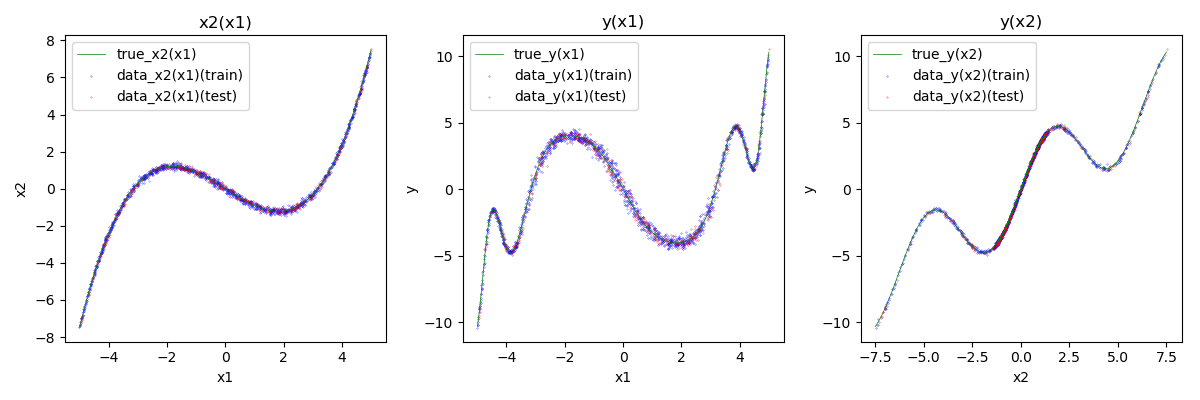

In [4]:
%matplotlib widget
fig= plt.figure(figsize=(12,4))
ax_pred_x1_x2= fig.add_subplot(1,3,1,title='x2(x1)',xlabel='x1',ylabel='x2')
ax_pred_x1_y= fig.add_subplot(1,3,2,title='y(x1)',xlabel='x1',ylabel='y')
ax_pred_x2_y= fig.add_subplot(1,3,3,title='y(x2)',xlabel='x2',ylabel='y')
true_x1= np.linspace(xmin,xmax,1000).reshape((-1,1))
true_x2= Func1(true_x1)
true_y= Func2(true_x2)
g= globals()
for a,b in (('x1','x2'),('x1','y'),('x2','y')):
  g[f'ax_pred_{a}_{b}'].plot(g[f'true_{a}'], g[f'true_{b}'], color='green', linewidth=0.5, label=f'true_{b}({a})')
  g[f'ax_pred_{a}_{b}'].scatter(g[f'data_{a}'][idxes[:N_train]], g[f'data_{b}'][idxes[:N_train]], s=0.05, color='blue', label=f'data_{b}({a})(train)')
  g[f'ax_pred_{a}_{b}'].scatter(g[f'data_{a}'][idxes[N_train:]], g[f'data_{b}'][idxes[N_train:]], s=0.05, color='red', label=f'data_{b}({a})(test)')
  g[f'ax_pred_{a}_{b}'].legend()
fig.tight_layout()

In [5]:
class TFCN1(torch.nn.Module):
  def __init__(self, p_dropout=0.02):
    super(TFCN1,self).__init__()
    self.net_fc1= torch.nn.Sequential(
          torch.nn.Linear(1, 100),
          torch.nn.LeakyReLU(inplace=True),
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(100, 100),
          torch.nn.LeakyReLU(inplace=True),
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(100, 1),
          )
    self.net_fc2= torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.LeakyReLU(inplace=True),
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(200, 200),
          torch.nn.LeakyReLU(inplace=True),
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(200, 200),
          torch.nn.LeakyReLU(inplace=True),
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(200, 1),
          )
  def forward(self, x):
    x2= self.net_fc1(x)
    y= self.net_fc2(x2)
    return x2,y

In [73]:
#Setup a neural network.
net= TFCN1()

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)

'''
NOTE: There are two reasons to make a loss function (f_loss) as a class.
1. To provide the state_dict() method to f_loss, which is used in FindLR, but not used in Fit, FitOneCycle.
2. To provide callbacks to access the local variables in Fit (concretely, i_epoch).
'''
class cmb_loss(TCallbacks):
  def __init__(self, f_loss_x2, f_loss_y, update_method, i_delay):
    self.f_loss_x2= f_loss_x2
    self.f_loss_y= f_loss_y
    self.update_method= update_method
    self.i_delay= i_delay
    self.i_epoch= 0
  def state_dict(self):
    return {'x2':self.f_loss_x2.state_dict(), 'y':self.f_loss_y.state_dict(), 'update_method':self.update_method, 'i_delay':self.i_delay, 'i_epoch':self.i_epoch}
  def load_state_dict(self, d):
    self.f_loss_x2.load_state_dict(d['x2'])
    self.f_loss_y.load_state_dict(d['y'])
    self.update_method,self.i_delay,self.i_epoch= d['update_method'], d['i_delay'], d['i_epoch']
  def cb_epoch_train_begin(self, l):
    self.i_epoch+= 1  #l.i_epoch
  def __call__(self, y, y_trg):
    pred_x2,pred_y= y
    trg_x2,trg_y= y_trg
    if self.update_method=='both':
      loss_x2= 0.2*self.f_loss_x2(pred_x2, trg_x2)
      loss_y= self.f_loss_y(pred_y, trg_y)
      return loss_x2+loss_y
    elif self.update_method=='only_y':
      loss_y= self.f_loss_y(pred_y, trg_y)
      return loss_y
    elif self.update_method=='delayed':
      loss_x2= 0.2*self.f_loss_x2(pred_x2, trg_x2)
      if self.i_epoch<=self.i_delay:  return loss_x2
      loss_y= self.f_loss_y(pred_y, trg_y)
      return loss_x2+loss_y

f_loss_x2= torch.nn.MSELoss()
f_loss_y= torch.nn.MSELoss()
# f_loss_x2= torch.nn.HuberLoss(reduction='mean', delta=0.2)
# f_loss_y= torch.nn.HuberLoss(reduction='mean', delta=1.0)
# update_method= 'both'
# update_method= 'only_y'
update_method= 'delayed'
i_delay= 5
f_loss= cmb_loss(f_loss_x2, f_loss_y, update_method, i_delay)
#Loss for FindLR:
f_loss_flr= cmb_loss(f_loss_x2, f_loss_y, 'only_y', None)

def rmse(y,y_trg):
  # print(f'debug; y={y},y_trg={y_trg}')
  pred_x2,pred_y= y
  trg_x2,trg_y= y_trg
  return torch.sqrt(torch.nn.functional.mse_loss(pred_y,trg_y))
f_metric= rmse

def decode(pred):
  return pred

def tfm_batch(batch):
  x1,x2,y= batch
  return torch.autograd.Variable(x1), (torch.autograd.Variable(x2), torch.autograd.Variable(y))

logger= TLogger()
disp= TDisp()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
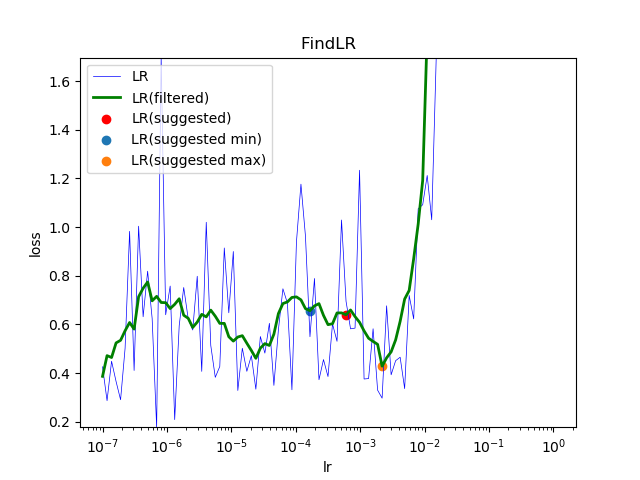

lr= 0.000602559586074358, lr_min=0.00016595869074375612, lr_max=0.0021877616239495525


In [82]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss_flr, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

loss(train)	loss(test)	metric(test)	time
0.48321134	0.29050021	0.51258856	0.298665
0.54219740	0.22178932	0.45282316	0.273296
0.48325584	0.21865796	0.45314652	0.258744
0.52211428	0.38387418	0.59447914	0.303026
0.71574419	0.40631378	0.61617898	0.258773
0.69246956	0.28081537	0.52053244	0.276504
0.66455171	0.36302105	0.58600560	0.268885
0.79515006	0.73024554	0.84505685	0.252646
0.66081966	0.30379359	0.54018485	0.270752
0.66945333	0.70239116	0.81735829	0.311430
0.64275153	0.39957490	0.60048034	0.262607
0.61512832	0.29042396	0.52710835	0.261283
0.48236816	0.32510898	0.55583227	0.272543
0.51748122	0.26912642	0.50933673	0.245529
0.49122946	0.22774107	0.46098077	0.245291
0.43701298	0.18838330	0.42375154	0.248677
0.47085160	0.17609125	0.41017478	0.271336
0.43328465	0.17946166	0.41029525	0.260769
0.37953579	0.17695901	0.40856554	0.258191
0.43843847	0.17568164	0.40877014	0.271165


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
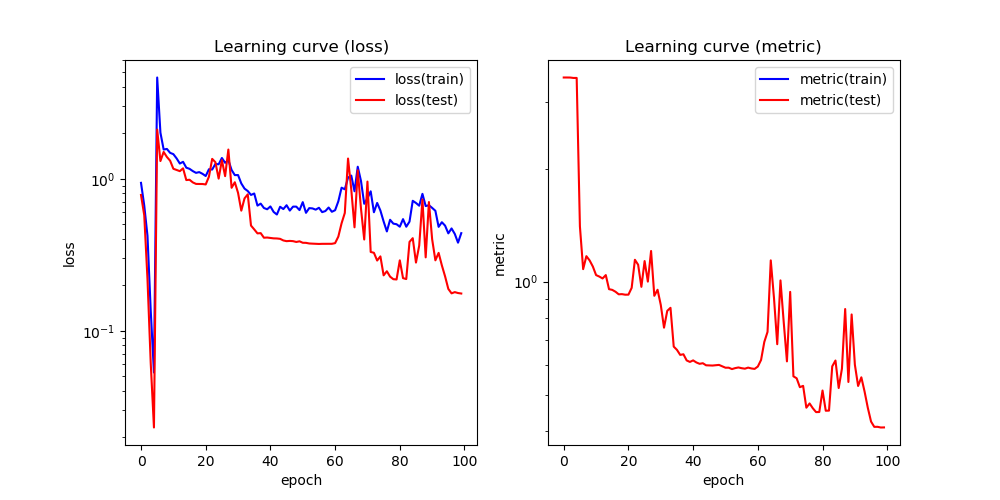

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
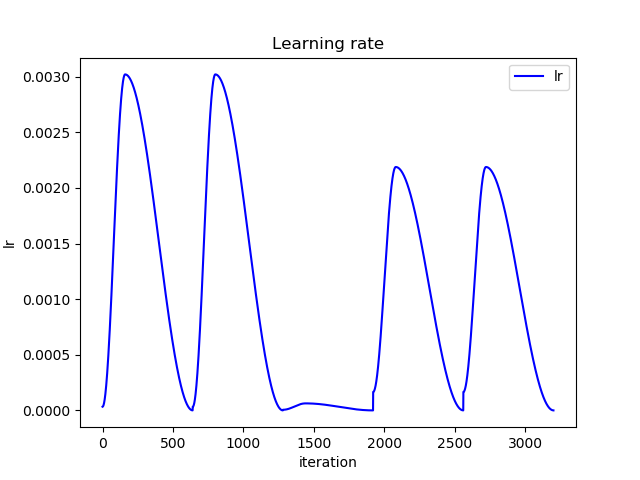

In [85]:
FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks(),f_loss.Callbacks()),    #<--NOTE: callbacks of f_loss.
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
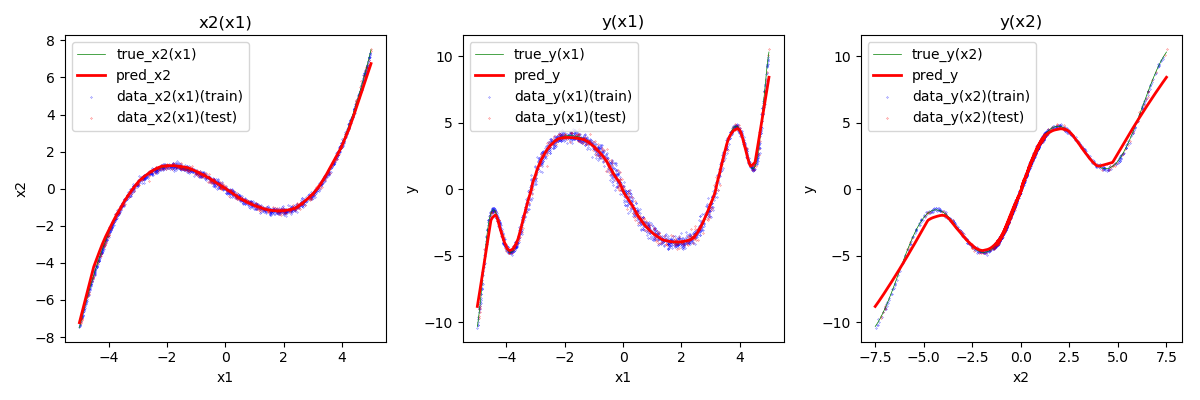

In [86]:
%matplotlib widget
fig= plt.figure(figsize=(12,4))
ax_pred_x1_x2= fig.add_subplot(1,3,1,title='x2(x1)',xlabel='x1',ylabel='x2')
ax_pred_x1_y= fig.add_subplot(1,3,2,title='y(x1)',xlabel='x1',ylabel='y')
ax_pred_x2_y= fig.add_subplot(1,3,3,title='y(x2)',xlabel='x2',ylabel='y')
true_x1= np.linspace(xmin,xmax,1000).reshape((-1,1))
true_x2= Func1(true_x1)
true_y= Func2(true_x2)
pred_x2,pred_y= map(lambda y:y.cpu(), decode(Eval(net, torch.from_numpy(true_x1).float(), device=device)))
g= globals()
for a,b in (('x1','x2'),('x1','y'),('x2','y')):
  g[f'ax_pred_{a}_{b}'].plot(g[f'true_{a}'], g[f'true_{b}'], color='green', linewidth=0.5, label=f'true_{b}({a})')
  g[f'ax_pred_{a}_{b}'].scatter(g[f'data_{a}'][idxes[:N_train]], g[f'data_{b}'][idxes[:N_train]], s=0.05, color='blue', label=f'data_{b}({a})(train)')
  g[f'ax_pred_{a}_{b}'].scatter(g[f'data_{a}'][idxes[N_train:]], g[f'data_{b}'][idxes[N_train:]], s=0.05, color='red', label=f'data_{b}({a})(test)')
  g[f'ax_pred_{a}_{b}'].plot(g[f'true_{a}'], g[f'pred_{b}'], color='red', linewidth=2, label=f'pred_{b}')
  g[f'ax_pred_{a}_{b}'].legend()
fig.tight_layout()